# Homework 4

Dylan Green, Student Number: 22420153

All code can be found at https://github.com/lone-duck/hw-cs532/tree/main/hw4

## Program 0 (Code)

My entire bbvi.py file is included below. Support code linked on Github above.

In [ ]:
# black box variational inference

import torch 
from primitives import eval_env
from graph_utils import topological_sort
import datetime
import wandb
import time
import numpy as np
import distributions

ENV = eval_env()

def init_Q(graph):
    """
    Initialize proposal distributions for bbvi
    Args:
        graph: graph dictionary
    Output:
        a dictionary Q containing initial proposal distributions
    """

    # get contents of graph
    fn_defs = graph[0]
    V = graph[1]['V']
    A = graph[1]['A']
    P = graph[1]['P']
    Y = graph[1]['Y']
    ret_vals = graph[2]    

    # deal with fn_defs
    global ENV
    ENV = eval_env()
    for defn in fn_defs.items():
        f_name = defn[0]
        f_v_is = defn[1][1]
        f_expr = defn[1][2]
        ENV.update({f_name: (f_v_is, f_expr)})

    # get sorted V
    sorted_V = topological_sort(A, V)

    Q = {}

    # find each q in order
    l = {}
    for v in sorted_V:
        task, expr = P[v][0], P[v][1]
        if task == "sample*":
            dist, _ = deterministic_evaluate(expr, l)
            l.update({v: dist.sample()})
            q = make_q(dist)
            Q.update({v: q})

    return Q

def make_q(d):
    
    # create a new q:
    if type(d) == torch.distributions.bernoulli.Bernoulli:
        probs = d.probs.clone().detach()
        q = distributions.Bernoulli(probs = probs)
    elif type(d) == torch.distributions.categorical.Categorical:
        probs = d.probs.clone().detach()
        q = distributions.Categorical(probs=probs)
    elif type(d) == torch.distributions.normal.Normal:
        loc = d.loc.clone().detach() 
        scale = d.scale.clone().detach()
        q = distributions.Normal(loc=loc, scale=scale)
    elif type(d) == torch.distributions.gamma.Gamma:
        concentration = d.concentration.clone().detach()
        rate = d.rate.clone().detach()
        q = distributions.Gamma(concentration=concentration, rate=rate)
    elif type(d) == torch.distributions.dirichlet.Dirichlet:
        concentration = d.concentration.clone().detach()
        q = distributions.Dirichlet(concentration=concentration)
    else:
        assert False, "Unknown distribution type: {}".format(type(d))

    return q


def bbvi_importance_sampling(graph, Q, L):
    """
    Given a proposal Q, generate weighted samples.
    Args:
        graph: the graph representing the FOPPL program
        Q: proposal distributions
        L: number of samples to generate
    Return:
        L samples and importance weights
    """

    # set up ENV
    fn_defs = graph[0]
    global ENV
    ENV = eval_env()
    for defn in fn_defs.items():
        f_name = defn[0]
        f_v_is = defn[1][1]
        f_expr = defn[1][2]
        ENV.update({f_name: (f_v_is, f_expr)})

    # get P, Y, sorted V
    P = graph[1]['P']
    V = graph[1]['V']
    Y = {k: torch.tensor(v).float() for k, v in graph[1]['Y'].items()}
    Xkeys = list(set(V) - set(Y.keys()))
    sorted_V = topological_sort(graph[1]['A'], V)
    ret_expr = graph[2]

    returns = [None]*L
    log_weights = [None]*L

    for l in range(L):
        returns[l], log_weights[l] = generate_sample(P, Q, Y, sorted_V, ret_expr)

    return {'returns': returns, 'log_weights': log_weights}


def generate_sample(P, Q, Y, sorted_V, ret_expr):
    logW = 0
    l = {}
    for v in sorted_V:
        task, expr = P[v][0], P[v][1]
        if task == "sample*":
            # get prior dist
            d, _ = deterministic_evaluate(expr, l)
            # get proposal
            q = Q[v]
            # take sample from proposal and add to l
            c = q.sample()
            l.update({v: c})
            # update logW
            logW += d.log_prob(c) - q.log_prob(c)
        elif task == "observe*":
            # get prior dist, add log prob of observation to logW
            d, _ = deterministic_evaluate(expr, l)
            c = Y[v]
            logW += d.log_prob(c)

    # TODO: generate return value
    ret = deterministic_evaluate(ret_expr, l)[0]
            
    return ret, logW
            




def bbvi_train(graph, T, L, base_string, Q=None, time_based=False, time_T=3600, lr=0.1, no_b=False, logging=True):
    """
    Trains BBVI proposal distributions.
    Args:
        graph: the graph denoting the problem
        T: number of outer training loops
        L: number of samples to use in gradient estimate
        Q: proposal distributions to start from... allows for 
           continuation of training from previously trained Q
    Returns:
        a new dictionary Q containing learned proposals
    """

    best_elbo = -np.inf
    
    if time_based:
        start = time.time()
    project_name = base_string
    if logging:
        wandb.init(project=project_name, entity="lone-duck")

    if Q is None:
        Q = init_Q(graph)

    # set up ENV
    fn_defs = graph[0]
    global ENV
    ENV = eval_env()
    for defn in fn_defs.items():
        f_name = defn[0]
        f_v_is = defn[1][1]
        f_expr = defn[1][2]
        ENV.update({f_name: (f_v_is, f_expr)})

    # get P, Y, sorted V
    P = graph[1]['P']
    V = graph[1]['V']
    Y = {k: torch.tensor(v).float() for k, v in graph[1]['Y'].items()}
    Xkeys = list(set(V) - set(Y.keys()))
    sorted_V = topological_sort(graph[1]['A'], V)

    # for t iterations, or for time_T seconds
    for t in range(T):
        # initiliaze lists for logW, G
        logWs = [None]*L
        Gs = [None]*L
        # "evaluate", i.e. sample from proposal and get logWs, Gs
        for l in range(L):
            logWs[l], Gs[l] = evaluation(P, Q, Y, sorted_V)
        # compute noisy elbo gradients
        g = elbo_gradients(logWs, Gs, L, Xkeys, no_b)
        # compute elbo
        elbo = compute_elbo(logWs)
        if elbo > best_elbo:
            best_Q = Q
            best_elbo = elbo
            print("new best elbo:")
            print(elbo)
        # do an update
        Q = update_Q(Q, g, t+1, lr)
        if logging:
            wandb.log({"ELBO": elbo})
        if time_based:
            if time.time() - start > time_T:
                break

    return best_Q


def update_Q(Q, g, t, lr):

    alpha = lr/torch.sqrt(torch.tensor(1.0*t))
    new_Q = {}

    for v in Q.keys():
        old_params = Q[v].Parameters()
        gradient = g[v]
        new_params = [(p + alpha*grad).clone().detach() for p, grad in zip(old_params, gradient)]
        new_Q[v] = type(Q[v])(*new_params, copy=True)

    return new_Q

    
def compute_elbo(logWs):
    
    return torch.mean(torch.stack(logWs))


def elbo_gradients(logWs, Gs, L, Xkeys, no_b):

    g = {}

    for v in Xkeys:
        # compute Fv's, Gv's for this v
        Fv = [None]*L
        Gv = [None]*L
        for l in range(L):
            if v in Gs[l]:
                Fv[l] = torch.stack(Gs[l][v]) * logWs[l]
                Gv[l] = torch.stack(Gs[l][v])
            else:
                Fv[l], Gv[l] = torch.tensor(0.), torch.tensor(0.)
        # both of shape (L, G.size())
        Fv = torch.stack(Fv)
        Gv = torch.stack(Gv)
        assert Fv.dim() < 3, "Need to ensure things work for higher dimensions"
        assert Gv.dim() < 3, "Need to ensure things work for higher dimensions"
        # compute b for this v
        if no_b:
            b = 0
        else:
            b = compute_b(Fv, Gv)
        g[v] = torch.sum(Fv - b*Gv, dim=0)/L

    return g

def compute_b(F, G):

    L, d = F.size()

    if d == 1:
        num = torch.sum((F - torch.mean(F))*(G - torch.mean(G)))/(L-1)
        den = torch.std(G)**2
    else:
        num = torch.tensor(0.)
        den = torch.tensor(0.)
        for i in range(d):
            num += torch.sum((F[:,i] - torch.mean(F[:,i]))*(G[:,i] - torch.mean(G[:,i])))/(L-1)
            den += torch.std(G[:,i])**2

    return num/den 


def evaluation(P, Q, Y, sorted_V):
    logW = 0
    G = {}
    l = {}

    for v in sorted_V:
        task, expr = P[v][0], P[v][1]
        if task == "sample*":
            # get prior dist
            d, _ = deterministic_evaluate(expr, l)
            # get proposal and grad-able proposal
            q = Q[v]
            q_with_grad = q.make_copy_with_grads()
            # take sample from proposal and add to l
            c = q.sample()
            l.update({v: c})
            # update logW
            with torch.no_grad():
                logW += d.log_prob(c) - q.log_prob(c)
            # get gradient
            log_prob_q = q_with_grad.log_prob(c)
            log_prob_q.backward()
            G[v] = [param.grad for param in q_with_grad.Parameters()]
        elif task == "observe*":
            # get prior dist, add log prob of observation to logW
            d, _ = deterministic_evaluate(expr, l)
            c = Y[v]
            with torch.no_grad():
                logW += d.log_prob(c)

    return logW, G


def deterministic_evaluate(e, l, sig=None):
    # variable reference OR procedure OR just a string
    if isinstance(e, str):        
        # global procedures take precedence over locally defined vars
        if e in ENV:
            return ENV[e], sig
        elif e in l:
            return l[e], sig
        # could allow for hashmaps with string keys; for debugging setting this to fail
        else:
            assert False, "Unknown symbol: {}".format(e)
    # constant number
    elif isinstance(e, (int, float)):   
        return torch.tensor(float(e)), sig
    # if statements
    elif e[0] == 'if':
        (_, test, conseq, alt) = e
        exp = (conseq if deterministic_evaluate(test, l)[0] else alt)
        return deterministic_evaluate(exp, l)
    # let statements
    elif e[0] == 'let':
        # get symbol
        symbol = e[1][0]
        # get value of e1
        value, _ = deterministic_evaluate(e[1][1], l)
        # evaluate e2 with value 
        return deterministic_evaluate(e[2], {**l, symbol: value})
    # sample statement
    if e[0] == 'sample':
        dist = deterministic_evaluate(e[1], l)[0]
        # make sure it is a distribution object
        assert getattr(dist, '__module__', None).split('.')[:2] == ['torch', 'distributions']
        return dist.sample(), sig
    # obsere statements
    # TODO: change this, maybe in this hw or for hw3
    if e[0] == 'observe':
        dist = deterministic_evaluate(e[1], l)[0] # get dist
        y = deterministic_evaluate(e[2], l)[0]    # get observed value
        # make sure it is a distribution object
        assert getattr(dist, '__module__', None).split('.')[:2] == ['torch', 'distributions']
        # TODO: do something with observed value
        return dist.sample(), sig
    # procedure call, either primitive or user-defined
    else:
        result = deterministic_evaluate(e[0], l)
        proc, sig = result
        # primitives are functions
        if callable(proc):
            args = [deterministic_evaluate(arg, l)[0] for arg in e[1:]]
            result, sig = proc(*args), sig
            return result, sig
        # user defined functions are not
        else:
            # as written in algorithm 6
            v_is, e0 = proc 
            assert(len(v_is) == len(e[1:]))
            c_is = [deterministic_evaluate(arg, l)[0] for arg in e[1:]]
            l_proc = dict(zip(v_is, c_is))
            return deterministic_evaluate(e0, {**l, **l_proc})

## Program 1

A bit of housekeeping first...

In [14]:
import torch
import json
import pickle
import numpy as np
from bbvi import bbvi_importance_sampling
import matplotlib.pyplot as plt
import scipy.stats

f = open('graphs/p1.json', 'rb')
g1 = json.load(f)
f.close()
f = open('graphs/p2.json', 'rb')
g2 = json.load(f)
f.close()
f = open('graphs/p3_hw3.json', 'rb')
g3 = json.load(f)
f.close()
f = open('graphs/p4.json', 'rb')
g4 = json.load(f)
f.close()

with open('pickles/Q1', 'rb') as f:
    Q1 = pickle.load(f)
with open('pickles/Q2', 'rb') as f:
    Q2 = pickle.load(f)
with open('pickles/Q3', 'rb') as f:
    Q3 = pickle.load(f)
with open('pickles/Q4_100', 'rb') as f:
    Q4_100 = pickle.load(f)
with open('pickles/Q4_1000', 'rb') as f:
    Q4_1000 = pickle.load(f)

A plot of the BBVI loss as a function of optimizer step is below. This program was optimized for 10 minutes (outer loop based on time rather than iteration count). The maximum ELBO achieved was -8.239.

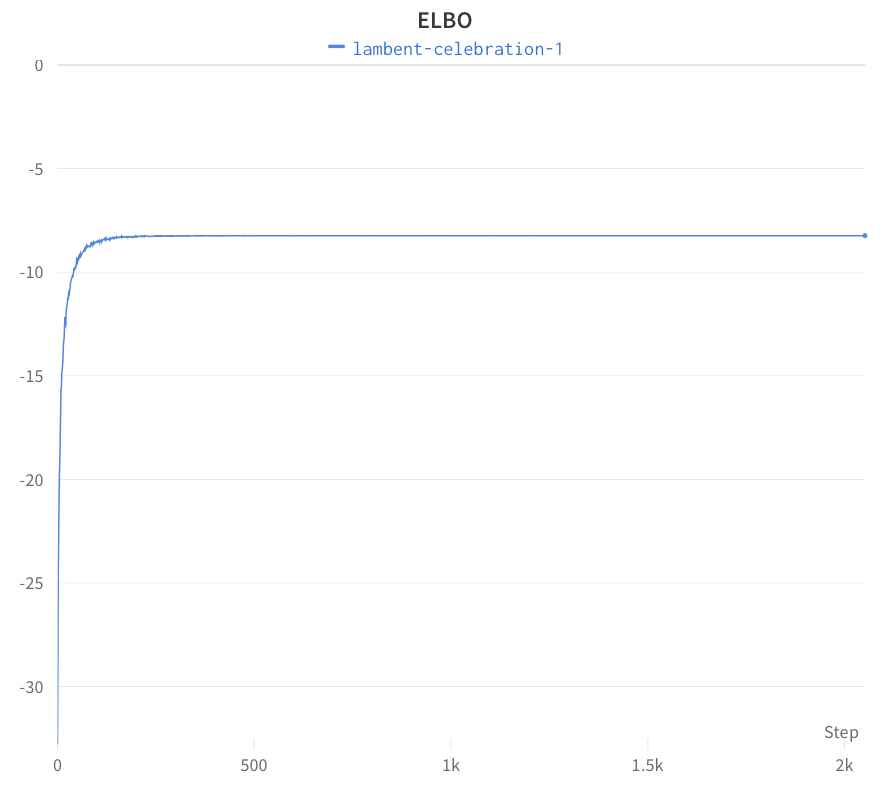

Computing the posterior expected value of `mu`: 

In [7]:
result = bbvi_importance_sampling(g1, Q1, L=10000)

In [8]:
returns = torch.stack(result['returns']).float()
log_weights = torch.stack(result['log_weights'])
M = torch.max(log_weights)
normalized_weights = torch.exp(log_weights - M)/torch.sum(torch.exp(log_weights - M))
weighted_returns = normalized_weights*returns
expectation = torch.sum(weighted_returns)
print("Expectation: {}".format(expectation.item()))

Expectation: 7.247315406799316


The variational distribution for `mu` is:

In [10]:
Q1['sample2']

Normal(loc: 7.249859809875488, scale: 0.9132271409034729)

A plot of the pdf:

Text(0.5, 1.0, 'Variation Distribution of $\\mu$')

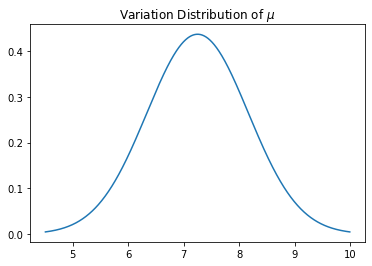

In [17]:
mean = Q1['sample2'].loc.numpy()
std = Q1['sample2'].scale.numpy()
x = np.linspace(mean-3*std, mean+3*std, 1000)
y = scipy.stats.norm.pdf(x, mean, std)
plt.plot(x,y)
plt.title('Variation Distribution of $\mu$')

## Program 2

Plots of the BBVI loss vs. optimizer step for this program. I did three 10 minute rounds of training for this program, each time starting from the final set of proposals generated in the last round. L was increased each time and the learning rate was decreased in an effort to get an ELBO in line with what was being reported on Slack. The maximum ELBO value reached was -13.88.

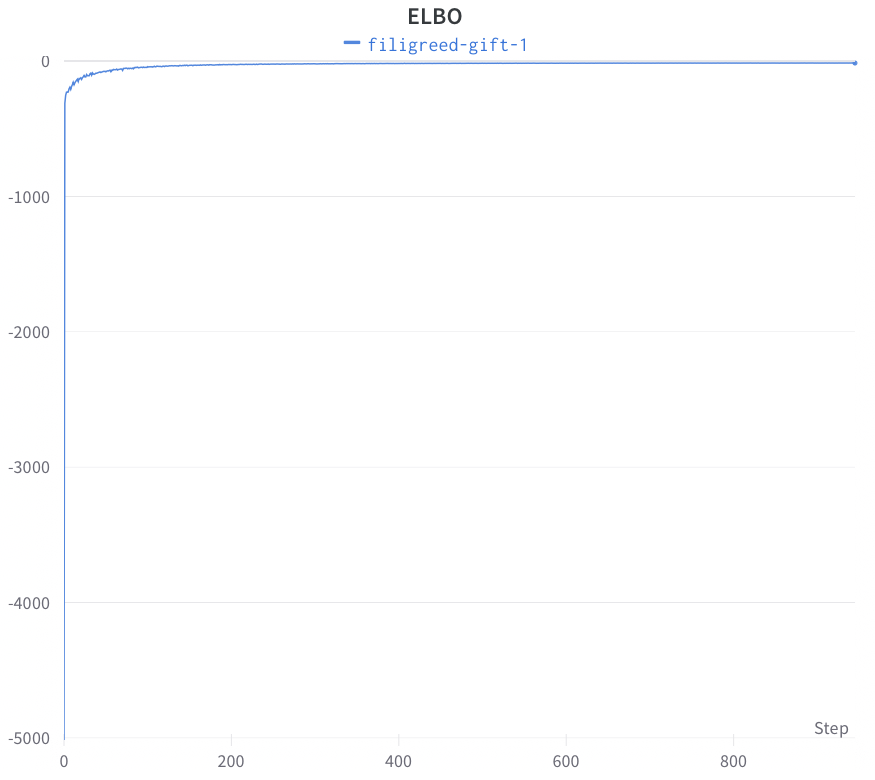

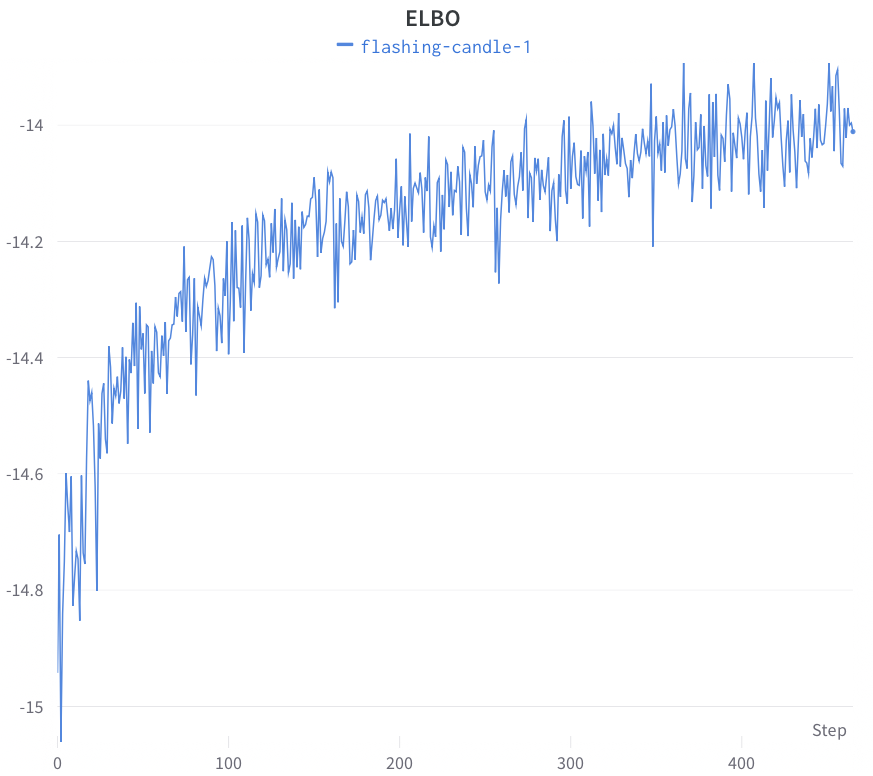

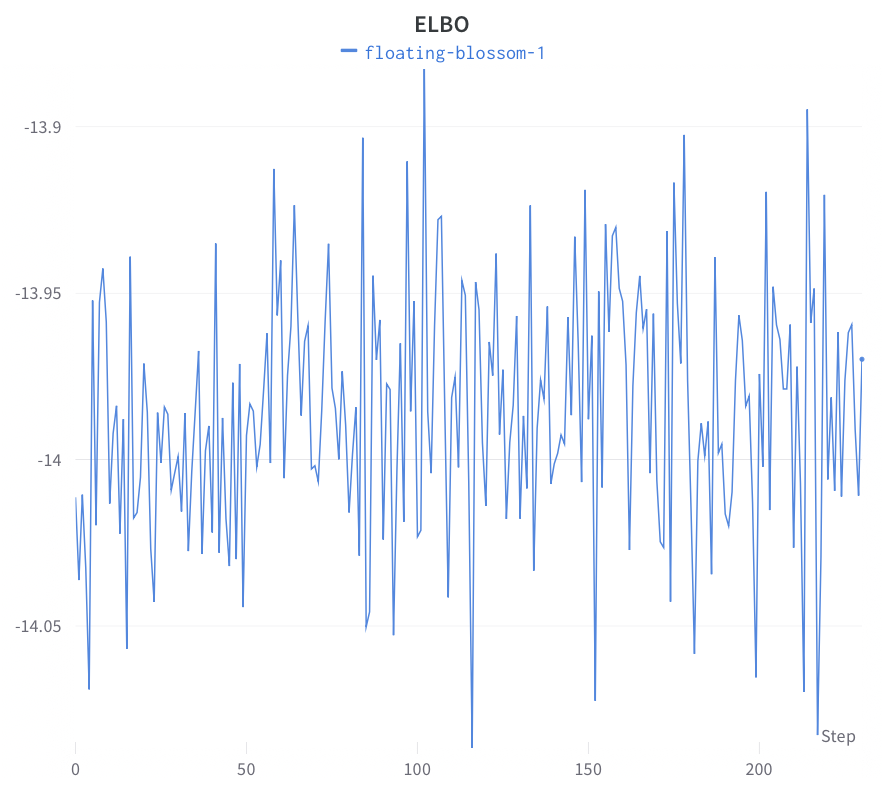

Computing the posterior expected values of `slope` and `bias` respectively:

In [20]:
result = bbvi_importance_sampling(g2, Q2, L=10000)
returns = torch.stack(result['returns']).float()
log_weights = torch.stack(result['log_weights'])
M = torch.max(log_weights)
normalized_weights = torch.exp(log_weights - M)/torch.sum(torch.exp(log_weights - M))
weighted_returns = normalized_weights.unsqueeze(dim=1)*returns
expectation = torch.sum(weighted_returns, dim=0)
print("Expectation: {}".format(expectation.numpy()))

Expectation: [ 2.1450531  -0.47503355]


# Program 3

For this program I had a lot of trouble getting it to run at all; because the initial proposal distributions came from the prior, and the data is very unlikely under the prior, the starting ELBO would often start on the magnitude of -10^6. The first parameter update would then often result in invalid distribution parameters and/or an even worse proposal, and nans would quickly show up. To fix this, I hardcoded the Gamma distributions so that the samples sigmas would have large magnitudes and the observations would not have such large negative log probabilities. This made training much more stable, but I also noticed that the final learned parameters for the Gammas are not so different from what I set them to - I'm not sure if I've irreversibly biased my proposals towards something incorrect. 

A plot of ELBO vs. optimizer step is shown below. This was run for 1 hour; it appears to still be making progress, so training longer would likely give better results. 

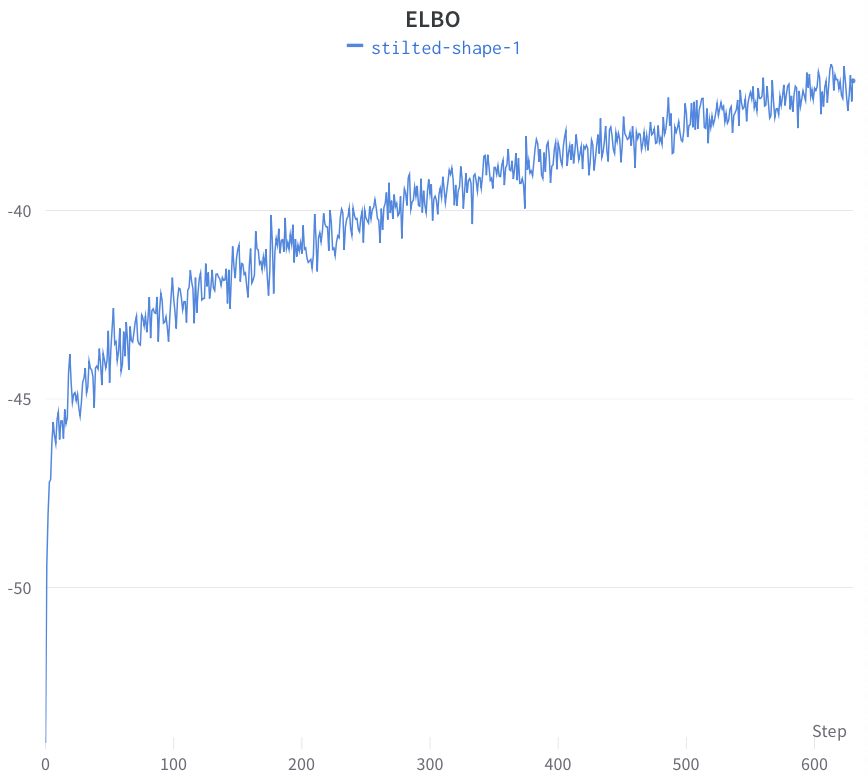

The posterior probability that `(= (first z) (second z)`:

In [39]:
result = bbvi_importance_sampling(g3, Q3, L=1000)
returns = torch.stack(result['returns']).float()
log_weights = torch.stack(result['log_weights'])
M = torch.max(log_weights)
normalized_weights = torch.exp(log_weights - M)/torch.sum(torch.exp(log_weights - M))
weighted_returns = normalized_weights*returns
expectation = torch.sum(weighted_returns)
print("Expectation: {}".format(expectation.item()))

Expectation: 0.6752511262893677


(As in the last assignment, I'll note that results here are somewhat noisy from run to run).

Regarding the problems with symmetric modes in programs like this, the symmetries arise because since all mixture components have the same distribution type the likelihood invariant to permutations of the mixture indices (or labels). Thus we get one mode for each permutation of the labels. Since VI is mode-seeking, if the true posterior is not representable under the joint variational family we are using (or perhaps even if it is) there will be local minima where the variational distribution models one or a few of the symmetric modes well while ignoring the others.  

# Program 4

Because this program is quite time consuming relative to the others, I decided to run two scripts in parallel; one with `L=100` and one with `L=1000`, each for an hour. The one with `L=100` is shown first below. The maximum ELBO for `L=1000` was -453, and for `L=100` it was -452, so there wasn't much difference in the end.

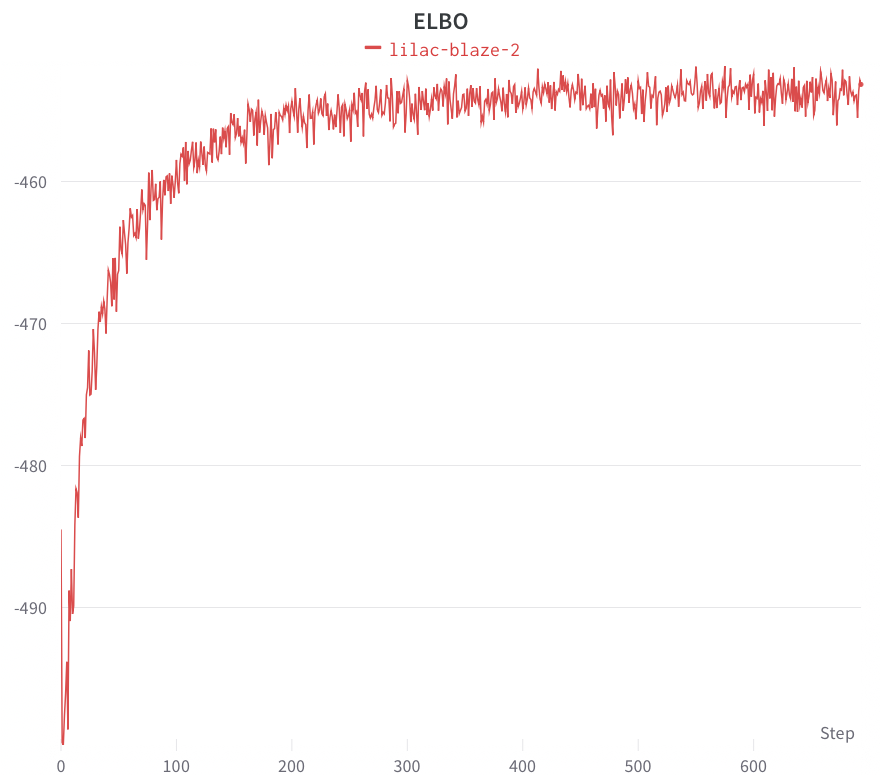

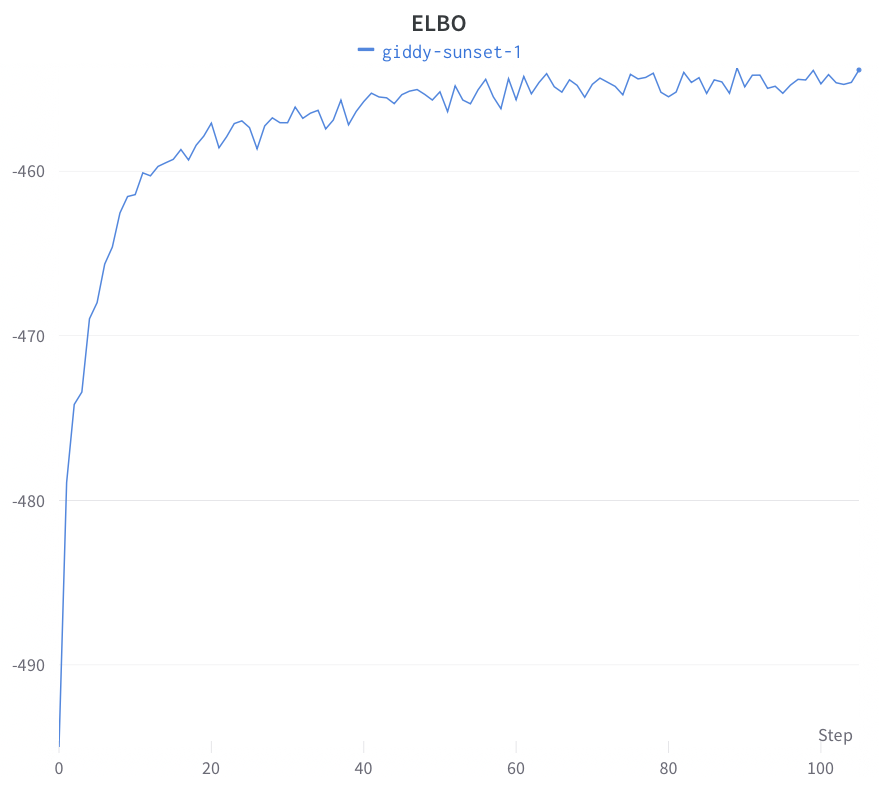

Generating the requested quantities, using only the `L=100` parameters due to them having a slightly larger ELBO:

In [40]:
result = bbvi_importance_sampling(g4, Q4_100, L=1000)

In [63]:
returns = result['returns']
log_weights = torch.stack(result['log_weights'])
M = torch.max(log_weights)
normalized_weights = torch.exp(log_weights - M)/torch.sum(torch.exp(log_weights - M))
W_0s = [None]*1000
b_0s = [None]*1000
W_1s = [None]*1000
b_1s = [None]*1000
weighted_W_0s = [None]*1000
weighted_b_0s = [None]*1000
weighted_W_1s = [None]*1000
weighted_b_1s = [None]*1000
for i in range(1000):
    W_0s[i] = returns[i][0] 
    b_0s[i] = returns[i][1] 
    W_1s[i] = returns[i][2] 
    b_1s[i] = returns[i][3] 
    weighted_W_0s[i] = returns[i][0] * normalized_weights[i]
    weighted_b_0s[i] = returns[i][1] * normalized_weights[i]
    weighted_W_1s[i] = returns[i][2] * normalized_weights[i]
    weighted_b_1s[i] = returns[i][3] * normalized_weights[i]
W_0s = torch.stack(W_0s)
b_0s = torch.stack(b_0s)
W_1s = torch.stack(W_1s)
b_1s = torch.stack(b_1s)
weighted_W_0s = torch.stack(weighted_W_0s)
weighted_b_0s = torch.stack(weighted_b_0s)
weighted_W_1s = torch.stack(weighted_W_1s)
weighted_b_1s = torch.stack(weighted_b_1s)

I'm not too sure what is meant by "report the distributions of all the return tensors as heatmaps"... the only way I can picture this is by plotting heat maps of the means and standard deviations of each tensor. These are given below, along with simply printing these values. 

In [64]:
mean_W_0s = torch.mean(weighted_W_0s ,dim=0).numpy()
mean_b_0s = torch.mean(weighted_b_0s ,dim=0).numpy()
mean_W_1s = torch.mean(weighted_W_1s ,dim=0).numpy()
mean_b_1s = torch.mean(weighted_b_1s ,dim=0).numpy()
var_W_0s = torch.sum(weighted_W_0s*W_0s ,dim=0).numpy() - mean_W_0s**2
var_b_0s = torch.sum(weighted_b_0s*b_0s ,dim=0).numpy() - mean_b_0s**2
var_W_1s = torch.sum(weighted_W_1s*W_1s ,dim=0).numpy() - mean_W_1s**2
var_b_1s = torch.sum(weighted_b_1s*b_1s ,dim=0).numpy() - mean_b_1s**2

In [65]:
import seaborn as sns
sns.set_theme()

Text(0.5, 1.0, 'W_0 means')

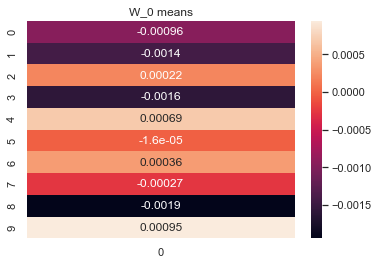

In [72]:
sns.heatmap(mean_W_0s, annot=True)
plt.title("W_0 means")

Text(0.5, 1.0, 'W_0 vars')

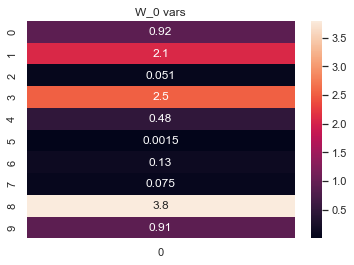

In [73]:
sns.heatmap(var_W_0s, annot=True)
plt.title("W_0 vars")

Text(0.5, 1.0, 'b_0 means')

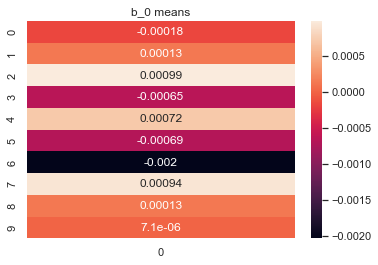

In [74]:
#b_0 mean and var
sns.heatmap(mean_b_0s, annot=True)
plt.title("b_0 means")

Text(0.5, 1.0, 'b_0 vars')

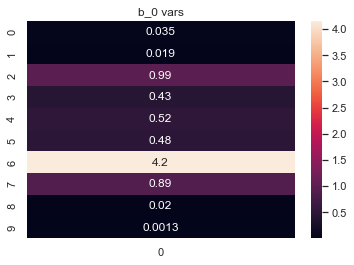

In [75]:
sns.heatmap(var_b_0s, annot=True)
plt.title("b_0 vars")

Text(0.5, 1.0, 'W_1 means')

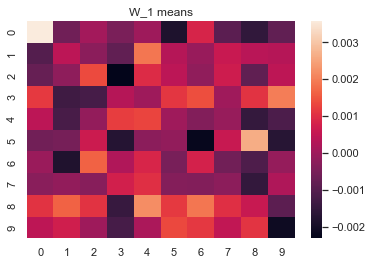

In [77]:
# annotation looks bad here
sns.heatmap(mean_W_1s)
plt.title("W_1 means")

Text(0.5, 1.0, 'W_1 vars')

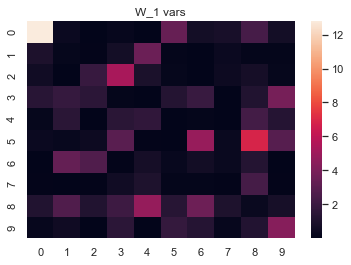

In [78]:
sns.heatmap(var_W_1s)
plt.title("W_1 vars")

Text(0.5, 1.0, 'b_1 means')

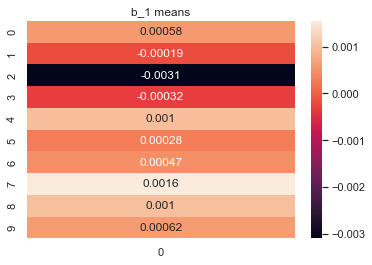

In [79]:
sns.heatmap(mean_b_1s, annot=True)
plt.title("b_1 means")

Text(0.5, 1.0, 'b_1 vars')

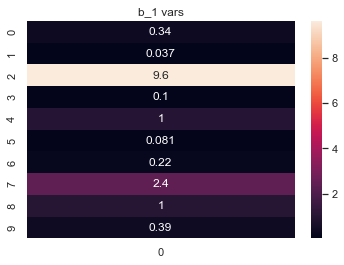

In [80]:
sns.heatmap(var_b_1s, annot=True)
plt.title("b_1 vars")

For the sake of completeness, also including the printed out values for W_1 since they didn't fit nicely in the plots. 

In [81]:
print(mean_W_1s)

[[ 3.5766133e-03 -6.2486483e-04  7.1690520e-05 -4.7403621e-04
   1.1357957e-05 -1.8436116e-03  8.3354424e-04 -9.0956513e-04
  -1.5446224e-03 -8.1822957e-04]
 [-9.9748909e-04  4.2173249e-04 -2.4134660e-04 -8.2205021e-04
   1.8796112e-03  3.2527390e-04 -6.3074855e-05  6.1043649e-04
   3.7662216e-04  3.1744607e-04]
 [-7.5986673e-04 -1.9797978e-04  1.3624734e-03 -2.3062360e-03
   9.5253473e-04  4.0710138e-04 -1.9097504e-04  6.6116877e-04
  -8.4355578e-04  4.3312632e-04]
 [ 1.1625560e-03 -1.3408916e-03 -1.2067818e-03  3.1898692e-04
   1.7487604e-06  1.1105100e-03  1.3936771e-03  2.0849340e-05
   1.0525223e-03  1.9719191e-03]
 [ 4.1995844e-04 -1.1892479e-03 -1.3974470e-04  1.1931116e-03
   1.2806141e-03  2.5143610e-05 -3.5836140e-04 -9.9926940e-05
  -1.5013403e-03 -1.1326725e-03]
 [-5.8942114e-04 -5.1998167e-04  6.5648626e-04 -1.7205584e-03
  -2.5821876e-04 -1.6296253e-04 -2.1952314e-03  5.7768507e-04
   2.6137447e-03 -1.6878590e-03]
 [-3.9056431e-05 -1.8218323e-03  1.6332947e-03  2.5676785e

In [82]:
print(var_W_1s)

[[1.28088598e+01 3.91987264e-01 6.46687532e-03 2.25798726e-01
  5.10324212e-03 3.40166211e+00 6.96759105e-01 8.30864310e-01
  2.39025331e+00 6.74994469e-01]
 [9.97774780e-01 1.78680345e-01 5.96532002e-02 6.79056227e-01
  3.54046416e+00 1.09471336e-01 4.90532815e-03 3.76981765e-01
  1.45517066e-01 1.02120399e-01]
 [5.79577923e-01 4.07276899e-02 1.85876834e+00 5.32505989e+00
  9.09503460e-01 1.67484418e-01 3.98590490e-02 4.40385967e-01
  7.14319170e-01 1.89061180e-01]
 [1.35518467e+00 1.80293310e+00 1.45820296e+00 1.02745496e-01
  9.70371126e-04 1.23608994e+00 1.94867313e+00 2.15446320e-03
  1.10973585e+00 3.89727545e+00]
 [1.78289577e-01 1.41759264e+00 2.11252328e-02 1.42594802e+00
  1.64461362e+00 1.94971578e-03 1.29604608e-01 1.31537374e-02
  2.25832009e+00 1.29160964e+00]
 [3.51507872e-01 2.71881610e-01 4.33683723e-01 2.96239424e+00
  6.80754110e-02 2.73308158e-02 4.82871342e+00 3.35992068e-01
  6.84262753e+00 2.85478497e+00]
 [5.00998786e-03 3.32587790e+00 2.67783523e+00 6.92208707e

For the "paragraph or two" part, I'll answer this in two ways, since it's unclear what the question is asking. 

If it is asking about score function gradients vs. pathwise gradients (it doesn't read this way to me but many people seem to have interpreted it this way), pathwise gradients have much lower variance but also require PDFs which are differentiable with respect to their rvs. In the context of probabilistic programming this introduces complications, since this is not true for all distributions (or any discrete distribution). Score function gradients have higher variance but can be applied to most (all?) distributions.

If the question is asking about Bayesian neural networks vs. point estimate methods for neural network training, the main difference is that a Bayesian approach allows us to account for epistemic uncertainty in the model parameters, which in practice often leads to better calibrated uncertainty estimates for predictions. 

# Program 5

It probably would have been best to ask during Thursday's office hour, but it is not entirely clear to me what should happen in this program when `abs(m) < 0.01`; i.e. how do we define `Uniform[0.01, abs(m)]` for `abs(m) < 0.01`? The version of torch that I am working with seems to allow for `high < low` (which I find quite strange... this has been addressed in a more recent torch update it seems from the source on the torch website). Alternatively, I could reject any `m` such that `abs(m) < 0.01`. This happens less than 1% of the time, and allowing for this case to result in `Uniform[abs(m), 0.01]` would lead to `nan` or near-`nan` log probabilities for the observe statement, so I will choose to reject values of `m` for which this is the case. 

I will use a Gamma for the variational distribution for `s`, as it has support on the positive real line and is flexible enough to concentrate around a unimodal posterior, supposing that one exists. To deal with the fact that the true support for `s` is $[0.01, \infty)$, I will deterministically add 0.01 to samples from the Gamma. Correspondingly, I will subtract 0.01 from these values before taking the log probability under the Gamma. To deal with the case where values sampled from the Gamma are greater than `abs(m)` I will simply resample until the value is within an allowable range. I'm not sure if this biases my results - I'll do some analytical work after submission to see if this is the case. See code below.

In [ ]:
def init_Q_p5(graph):
    """
    Initialize proposal distributions for bbvi
    Args:
        graph: graph dictionary
    Output:
        a dictionary Q containing initial proposal distributions
    """

    # get contents of graph
    fn_defs = graph[0]
    V = graph[1]['V']
    A = graph[1]['A']
    P = graph[1]['P']
    Y = graph[1]['Y']
    ret_vals = graph[2]    

    # deal with fn_defs
    global ENV
    ENV = eval_env()
    for defn in fn_defs.items():
        f_name = defn[0]
        f_v_is = defn[1][1]
        f_expr = defn[1][2]
        ENV.update({f_name: (f_v_is, f_expr)})

    # get sorted V
    sorted_V = topological_sort(A, V)

    Q = {}

    # find each q in order
    l = {}
    for v in sorted_V:
        task, expr = P[v][0], P[v][1]
        if task == "sample*":
            dist, _ = deterministic_evaluate(expr, l)
            l.update({v: dist.sample()})
            if v == 'sample1':
                q = make_q(dist)
            else:
                q = distributions.Gamma(torch.tensor(1.), torch.tensor(1.))
            Q.update({v: q})

    return Q


def bbvi_train_p5(graph, T, L, base_string, Q=None, time_based=False, time_T=3600, lr=0.1, no_b=False, logging=True):
    """
    Trains BBVI proposal distributions.
    Args:
        graph: the graph denoting the problem
        T: number of outer training loops
        L: number of samples to use in gradient estimate
        Q: proposal distributions to start from... allows for 
           continuation of training from previously trained Q
    Returns:
        a new dictionary Q containing learned proposals
    """

    best_elbo = -np.inf
    
    if time_based:
        start = time.time()
    project_name = base_string
    if logging:
        wandb.init(project=project_name, entity="lone-duck")

    if Q is None:
        Q = init_Q_p5(graph)

    # set up ENV
    fn_defs = graph[0]
    global ENV
    ENV = eval_env()
    for defn in fn_defs.items():
        f_name = defn[0]
        f_v_is = defn[1][1]
        f_expr = defn[1][2]
        ENV.update({f_name: (f_v_is, f_expr)})

    # get P, Y, sorted V
    P = graph[1]['P']
    V = graph[1]['V']
    Y = {k: torch.tensor(v).float() for k, v in graph[1]['Y'].items()}
    Xkeys = list(set(V) - set(Y.keys()))
    sorted_V = topological_sort(graph[1]['A'], V)

    # for t iterations, or for time_T seconds
    for t in range(T):
        # initiliaze lists for logW, G
        print(t)
        logWs = [None]*L
        Gs = [None]*L
        # "evaluate", i.e. sample from proposal and get logWs, Gs
        for l in range(L):
            logW = None
            samples = 0
            while logW is None:
                samples += 1
                logW, G = evaluation_p5(P, Q, Y, sorted_V)
            logWs[l], Gs[l] = logW, G
        # compute noisy elbo gradients
        g = elbo_gradients(logWs, Gs, L, Xkeys, no_b)
        # compute elbo
        elbo = compute_elbo(logWs)
        if elbo > best_elbo:
            best_Q = Q
            best_elbo = elbo
            print("new best elbo:")
            print(elbo)
            print("Q")
            print(Q)
        # do an update
        Q = update_Q(Q, g, t+1, lr)
        if logging:
            wandb.log({"ELBO": elbo})
        if time_based:
            if time.time() - start > time_T:
                break

    return best_Q


def evaluation_p5(P, Q, Y, sorted_V):
    logW = 0
    G = {}
    l = {}

    # we know the order here... code looks less ugly just doing 
    # things manually

    # sample1 (m)
    v = 'sample1'
    expr = P[v][1]
    d, _ = deterministic_evaluate(expr, l)
    q = Q[v]
    q_with_grad = q.make_copy_with_grads()
    m = q.sample()
    while torch.abs(m) < 0.01:
        m = q.sample()
    l.update({v: m})
    with torch.no_grad():
        logW += d.log_prob(m) - q.log_prob(m)
    log_prob_q = q_with_grad.log_prob(m)
    log_prob_q.backward()
    G[v] = [param.grad for param in q_with_grad.Parameters()]

    # sample2 (s)
    v = 'sample2'
    expr = P[v][1]
    d, _ = deterministic_evaluate(expr, l)
    q = Q[v]
    q_with_grad = q.make_copy_with_grads()
    s = q.sample() + 0.01
    high = torch.abs(m)
    number_tries = 0
    while s > high:
        number_tries += 1
        if number_tries > 1000:
            return None, None
        s = q.sample() + 0.01
    l.update({v: s})
    with torch.no_grad():
        logW += d.log_prob(s) - q.log_prob(s-0.01)
    log_prob_q = q_with_grad.log_prob(s-0.01)
    log_prob_q.backward()
    G[v] = [param.grad for param in q_with_grad.Parameters()]

    # observe3
    v = 'observe3'
    expr = P[v][1]
    d, _ = deterministic_evaluate(expr, l)
    c = Y[v]
    with torch.no_grad():
        logW += d.log_prob(c)

    return logW, G

In training this, I noticed that with a learning rate of 0.1 the ELBO makes a large jump on the first parameter update and then tends to be stuck to that value with small variations. Sometimes these values are much higher than other times, suggesting that there may be bad local optima to get stuck in. As a result, I decided to retrain with a smaller learning rate of 0.001 where changes in the ELBO tend to be much smaller. Both of these cases are shown below. First, the ELBO vs. observation for the best parameters found (in terms of ELBO) with `lr=0.1` which achieved a maximum ELBO of around -12.5:

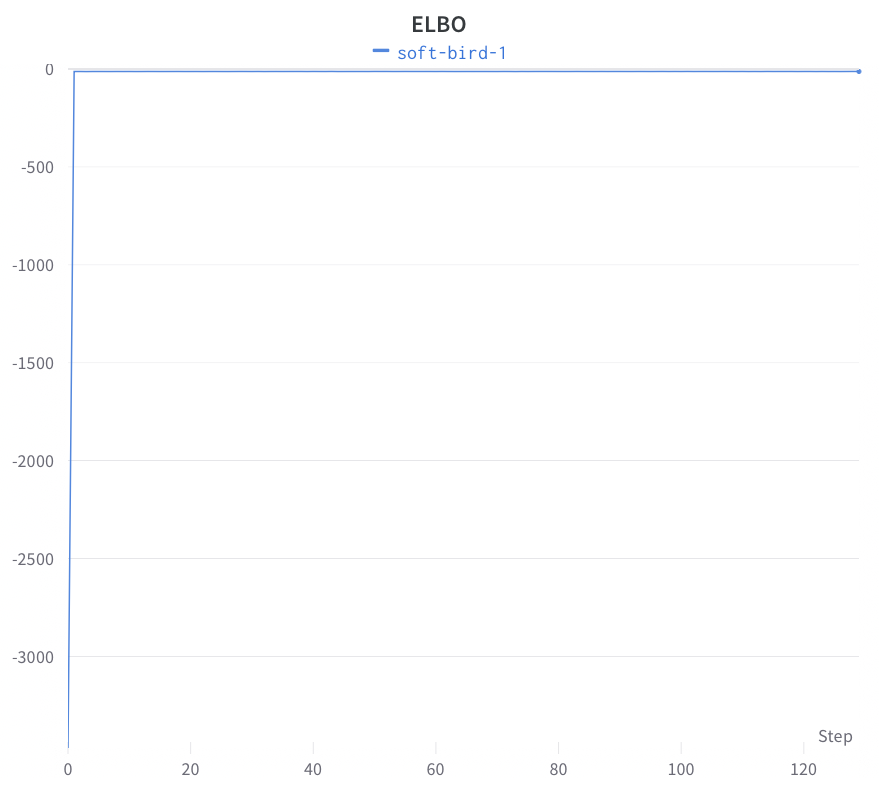

The variational distribution for `s`:

In [83]:
with open('pickles/q5', 'rb') as f:
    Q5 = pickle.load(f)
q = Q5['sample2']
print(q)

Gamma(concentration: 44.901668548583984, rate: 25.793577194213867)


Plotting this distribution with online tools for plotting Gamma distributions leads to distributions which look quite different from a histogram of samples from this posterior (I'm likely interpreting the mapping from concentration/rate to alpha/beta incorrectly). Plotting a histogram to ensure correctness:

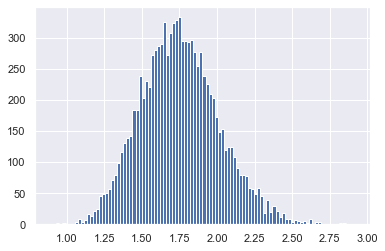

In [86]:
L = 10000
samples = [None]*L
for l in range(L):
    samples[l] = q.sample() + 0.01
plt.hist(torch.stack(samples).numpy(), bins=100)
print()

The ELBO vs. optimization step plot when using `lr=0.001` and trained for one hour. The maximum ELBO for this run was -25.31:

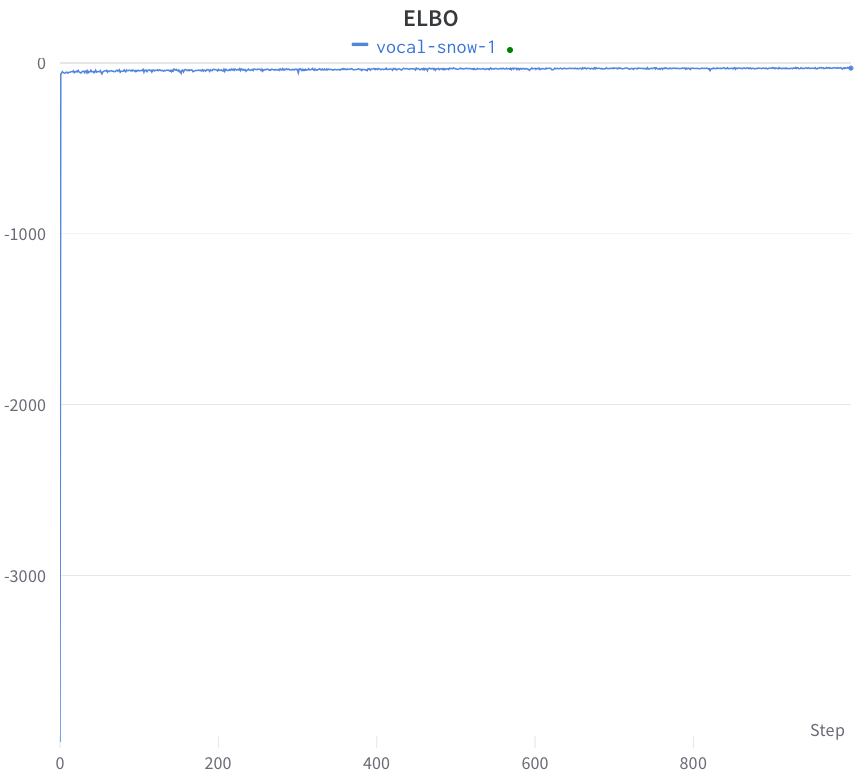

The variational distribution for `s` in this case:

In [89]:
with open('pickles/Q5_long', 'rb') as f:
    Q5_long = pickle.load(f)
q = Q5_long['sample2']
print(q)

Gamma(concentration: 5.796059608459473, rate: 3.107058525085449)


Plotting a histogram of this distribution:

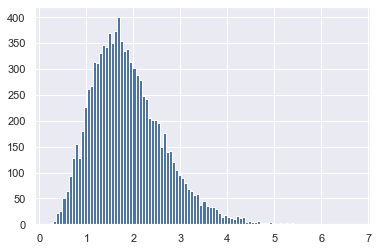

In [90]:
L = 10000
samples = [None]*L
for l in range(L):
    samples[l] = q.sample() + 0.01
plt.hist(torch.stack(samples).numpy(), bins=100)
print()

While the parameters of the distribution here are quite different, qualitatively the distributions are quite similar. As I stated above, I'm not sure that this approach did not bias my solution in some way, but the fact that both posteriors converged around a mode of ~1.75 is reassuring despite their different ELBO values and parameters. 